In [1]:
# Import necessary modules/libraries
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go

In [2]:
from utils import expected
def fair_opt_step(A, B, u_plus, u_minus, c_plus, c_minus, alpha):
    A = np.asarray(A)
    B = np.asarray(B)
    np.random.seed(1)

    w_a = len(A) / (len(A) + len(B))
    w_b = 1 - w_a

    mean_A, mean_B, util_A, util_B = change(A, B, c_plus, c_minus, u_plus, u_minus)

    fairness_diff = np.abs(mean_A - mean_B)
    total_util = w_a * util_A + w_b * util_B

    # Apply fairness constraint
    total_util_masked = np.where(fairness_diff <= alpha, total_util, -np.inf)

    # Find best pair (max utility under fairness constraint)
    flat_idx = np.argmax(total_util_masked)
    i, j = np.unravel_index(flat_idx, total_util.shape)

    opt_A = A[i]
    opt_B = B[j]
    updated_samples = (mean_A[i, j], mean_B[i, j])
    max_util = total_util_masked[i, j]

    return (opt_A, opt_B, max_util, updated_samples)

def change(A, B, c_plus, c_minus, u_plus, u_minus, prob=0.4):
    A = np.asarray(A)
    B = np.asarray(B)

    delta_A = expected(A, c_plus, c_minus)
    delta_B = expected(B, c_plus, c_minus)

    A_matrix = A[:, None]  # shape (n, 1)
    B_matrix = B[:, None]  # shape (m, 1)

    delta_A_matrix = delta_A[:, None]
    delta_B_matrix = delta_B[:, None]

    # Add small jitter to break ties
    jitter_A = np.random.choice([1e-8, -1e-8], size=A.shape, p=[0.4, 0.6])
    jitter_B = np.random.choice([1e-8, -1e-8], size=B.shape, p=[0.4, 0.6])

    A_matrix_adj = np.where(A_matrix + delta_A_matrix > A_matrix.T, A_matrix + delta_A_matrix, A_matrix)
    B_matrix_adj = np.where(B_matrix + delta_B_matrix > B_matrix.T, B_matrix + delta_B_matrix, B_matrix)

    # Break ties
    A_matrix_adj = np.where(A_matrix + delta_A_matrix == A_matrix.T, A_matrix + jitter_A[:, None], A_matrix_adj)
    B_matrix_adj = np.where(B_matrix + delta_B_matrix == B_matrix.T, B_matrix + jitter_B[:, None], B_matrix_adj)

    mean_A = np.mean(A_matrix_adj, axis=0)
    mean_B = np.mean(B_matrix_adj, axis=0)

    util_A = np.sum(expected(A_matrix_adj, u_plus, u_minus), axis=0)
    util_B = np.sum(expected(B_matrix_adj, u_plus, u_minus), axis=0)

    # Convert to meshgrids for threshold pairs
    mean_A_grid, mean_B_grid = np.meshgrid(mean_A, mean_B, indexing='ij')
    util_A_grid, util_B_grid = np.meshgrid(util_A, util_B, indexing='ij')

    return mean_A_grid, mean_B_grid, util_A_grid, util_B_grid


In [3]:
# Set experiment parameters
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
alpha_min, alpha_max = 0.01, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
n = 500

# Generate samples from normal distributions
a = np.random.normal(mean_a, std_a, n)
b = np.random.normal(mean_b, std_b, n)
a.sort(), b.sort()
w_a = len(a) / (len(a) + len(b))
w_b = 1 - w_a

#Step Parameters

# U+ / U- > C+ / C-
u_plus = 1
u_minus = -1.1
c_plus = 1
c_minus = -1
print( "Assumption 1: U+ / U- > C+ / C- is", (u_plus / u_minus) > (c_plus / c_minus) )

Assumption 1: U+ / U- > C+ / C- is True


In [4]:
# Single step optimization
from utils import opt_threshold, fair_opt_step, opt_step, expected

x_alphas = []
y_mean_A, y_mean_B = [], []
y_thresh_A, y_thresh_B = [], []
y_util = []
y_pof = [] # Price of fairness


y_opt_util = []

B_temp = None

opt_util_A, opt_util_B = opt_step(a, u_plus, u_minus, c_plus, c_minus)[0], opt_step(b, u_plus, u_minus, c_plus, c_minus)[0]
opt_util_A, opt_util_B  = expected(opt_util_A, 1, -1.1), expected(opt_util_B, 1, -1.1)
opt_util_A, opt_util_B = np.sum(opt_util_A), np.sum(opt_util_B)
y_opt = w_a * opt_util_A + w_b * opt_util_B

for alpha in tqdm(alphas):
    results = fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha)
    thresh_A, thresh_B, max_util, (A, B) = results
    temp_A = np.where(a>thresh_A, a+expected(a, c_plus, c_minus), a)
    temp_B = np.where(b>thresh_B, b+expected(b, c_plus, c_minus), b)
    #if np.mean(temp_A) != A or np.mean(temp_B) != B:
        #print(f'{np.mean(temp_A)} vs {A}')
        #print(f'{np.mean(temp_B)} vs {B}')
        #break
    if np.abs(A-B) > alpha:
        continue
    else:
        x_alphas.append(alpha)
        y_mean_A.append(A)
        y_mean_B.append(B)
        y_thresh_A.append(thresh_A)
        y_thresh_B.append(thresh_B)
        y_util.append(max_util)
        pof = 1 - (max_util/y_opt)
        y_pof.append(pof)

100%|██████████| 100/100 [00:07<00:00, 13.90it/s]


In [5]:
def plot_graphs():
    
    # Traces
    thresholds_A = go.Scatter(x=x_alphas, y=y_thresh_A, mode='markers', name="Fair Threshold (A)")
    thresholds_B = go.Scatter(x=x_alphas, y=y_thresh_B, mode='markers', name="Fair Threshold (B)") 
    utilities = go.Scatter(x=x_alphas, y=y_util, mode='markers', name='Utility', yaxis='y2')

    # Create figure
    fig = go.Figure(data=[thresholds_A, thresholds_B, utilities])

    # Add toggle buttons
    fig.update_layout(
        height = 600,
        title='Single Step Thresholding Policy',
        xaxis=dict(title="Alpha"),
        yaxis=dict(title="Threshold"),
        yaxis2=dict(
            title="Utility",
            overlaying="y",
            side="right"
        ),
        legend=dict(
            x=0,          # Right edge of the plotting area
            #y=1,          # Top of the plotting area
            xanchor='right',   # Legend's left edge aligns at x=1
            yanchor='top'     # Legend's top edge aligns at y=1
        ),
        showlegend=True,
    )

    fig.show()
plot_graphs()

In [12]:
# Experiment 2
from experiment_2 import experiment_2
test_alpha = 0.59
ex2a, ex2b = experiment_2(a, b, u_plus, u_minus, c_plus, c_minus, test_alpha, w_a, w_b, thresh_B, a, alphas)
ex2a.update_layout(
    xaxis_title ='Threshold A (using samples)'
)
ex2a.show()
ex2b.show()


100%|██████████| 1000/1000 [00:00<00:00, 10437.93it/s]


100%|██████████| 100/100 [13:06<00:00,  7.86s/it]


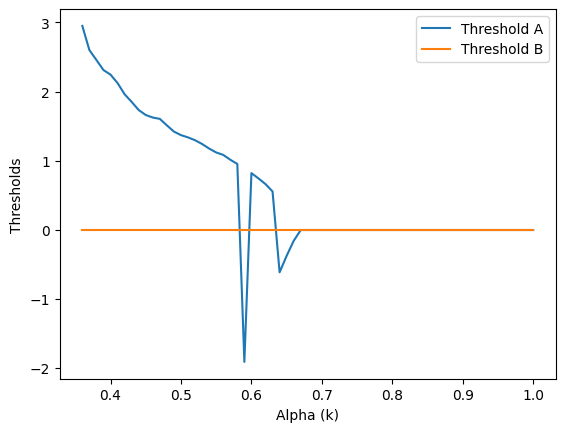

In [7]:
t_x = []
t_A, t_B = [], []

# Precompute expected values
d_A = expected(a, c_plus, c_minus)
d_B = expected(b, c_plus, c_minus)
u_A = expected(a, u_plus, u_minus)
u_B = expected(b, u_plus, u_minus)

for k in tqdm(alphas):
    t_util = -np.inf
    thresh_A = None
    thresh_B = None

    for i in a:
        for j in b:
            A = np.where(a > i, a + d_A, a)
            B = np.where(b > j, b + d_B, b)
            util = w_a * np.sum(A) + w_b * np.sum(B)

            # Enforce similarity constraint
            if np.abs(np.mean(A) - np.mean(B)) > k:
                continue

            if util > t_util:
                t_util = util
                thresh_A = i
                thresh_B = j

    if thresh_A is not None and thresh_B is not None:
        t_x.append(k)
        t_A.append(thresh_A)
        t_B.append(thresh_B)

# Plotting after loop
plt.plot(t_x, t_A, label='Threshold A')
plt.plot(t_x, t_B, label='Threshold B')
plt.xlabel("Alpha (k)")
plt.ylabel("Thresholds")
plt.legend()
plt.show()


In [11]:
threshA = go.Scatter(x=t_x, y=t_A, mode='markers', name="Threshold A")
threshB = go.Scatter(x=t_x, y=t_B, mode='markers', name="Threshold B")
fig = go.Figure(data=[threshA, threshB])
fig.show()

Output()

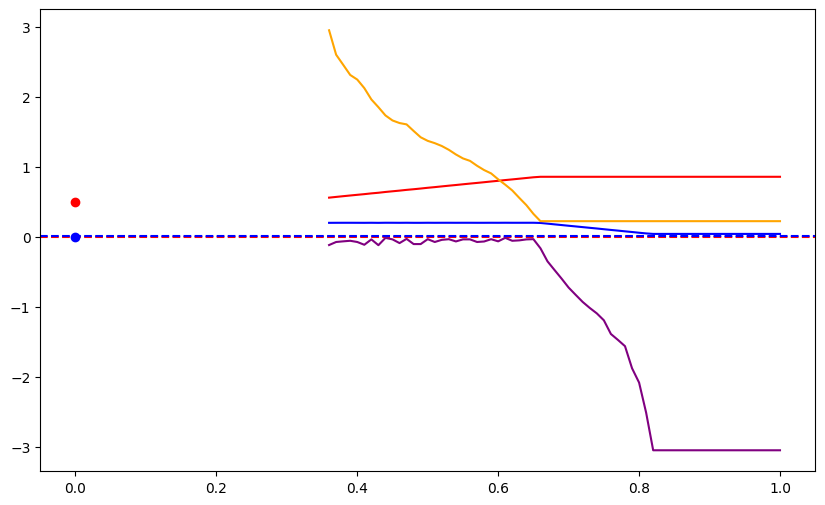

In [8]:
# Single step
from utils import fair_opt_step, opt_step
x = []
fair_mean_A = []
fair_mean_B = []
fair_threshold_A = []
fair_threshold_B = []
total_util = []

# Unconstrained optimal means
opt_result_A = opt_step(a, 1, -1, 1, -1)[1]
opt_result_B = opt_step(b, 1, -1, 1, -1)[1]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in alphas:
    results = fair_opt_step(a, b, 1, -1.1, 1, -1, alpha)
    if results is not None:
        A, B = results[3]
        if np.abs(A - B) > alpha:
            # Only store results if the fairness constraint is satisfied
            continue
        x.append(alpha)
        fair_mean_A.append(A)
        fair_mean_B.append(B)
        fair_threshold_A.append(results[0])
        fair_threshold_B.append(results[1])
        #total_util.append(((results[4])*0.01))

def plot_fairness(show_means=True, show_thresholds=True, show_utility=True):
    plt.figure(figsize=(10, 6))

    if show_means:
        plt.plot(x, fair_mean_A, label="Fair μ(A)'", color='red')
        plt.plot(x, fair_mean_B, label="Fair μ(B)'", color='blue')
        plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
        plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
        plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
        plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

    if show_thresholds:
        plt.plot(x, fair_threshold_A, label="Fair Threshold (A)", color='orange')
        plt.plot(x, fair_threshold_B, label="Fair Threshold (B)", color='purple')

    if show_utility:
        plt.plot(x, total_util, label='Total Utility', color='green')

    plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.xlabel("α (Fairness Threshold)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=True, description='Show Means')
thresholds_toggle = widgets.Checkbox(value=True, description='Show Thresholds')
utility_toggle = widgets.Checkbox(value=True, description='Show Utility')

ui = widgets.HBox([means_toggle, thresholds_toggle, utility_toggle])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_thresholds': thresholds_toggle,
    'show_utility': utility_toggle
})

display(ui, out)

100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


Output()

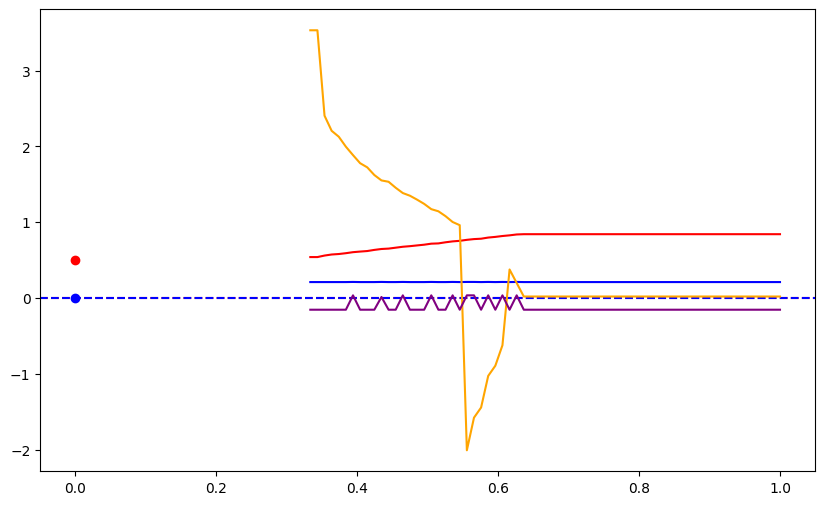

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from utils import opt_step 

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1

# Domain of alpha values to test
alpha_min, alpha_max = 0, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)

# Sample size of each distribution
sample_size = 1000

# Generate samples from normal distributions
np.random.seed(1)
a = np.random.normal(mean_a, std_a, sample_size)
b = np.random.normal(mean_b, std_b, sample_size)

# Store results
x = []
fair_mean_A = []
fair_mean_B = []
fair_threshold_A = []
fair_threshold_B = []
total_util = []

# Unconstrained optimal means
opt_result_A = opt_step(a, 1, -1, 1, -1)[1]
opt_result_B = opt_step(b, 1, -1, 1, -1)[1]
y3 = np.mean(opt_result_A)
y4 = np.mean(opt_result_B)

# Run fair optimization over a range of alpha values
for alpha in tqdm(alphas):
    results = fair_opt_step(a, b, 1, -1.1, 1, -1, alpha)
    if results is not None:
        A, B = results[3]
        if np.abs(A - B) > alpha:
            # Only store results if the fairness constraint is satisfied
            continue
        x.append(alpha)
        fair_mean_A.append(A)
        fair_mean_B.append(B)
        fair_threshold_A.append(results[0])
        fair_threshold_B.append(results[1])
        #total_util.append(((results[4])*0.01))

def plot_fairness(show_means=True, show_thresholds=True, show_utility=True):
    plt.figure(figsize=(10, 6))

    if show_means:
        plt.plot(x, fair_mean_A, label="Fair μ(A)'", color='red')
        plt.plot(x, fair_mean_B, label="Fair μ(B)'", color='blue')
        plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)\' (Unconstrained)')
        plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)\' (Unconstrained)')
        plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
        plt.plot(0, mean_b, 'bo', label='Initial μ(B)')

    if show_thresholds:
        plt.plot(x, fair_threshold_A, label="Fair Threshold (A)", color='orange')
        plt.plot(x, fair_threshold_B, label="Fair Threshold (B)", color='purple')

    if show_utility:
        plt.plot(x, total_util, label='Total Utility', color='green')

    plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.xlabel("α (Fairness Threshold)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=True, description='Show Means')
thresholds_toggle = widgets.Checkbox(value=True, description='Show Thresholds')
utility_toggle = widgets.Checkbox(value=True, description='Show Utility')

ui = widgets.HBox([means_toggle, thresholds_toggle, utility_toggle])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_thresholds': thresholds_toggle,
    'show_utility': utility_toggle
})

display(ui, out)